Tree-Based Models for Cryptocurrency Price Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from arch import arch_model
from sklearn.metrics import mean_absolute_error


df = pd.read_csv("/Users/kartik/github/cryptocurrency_market_analysis/merged_crypto_2023_2024.csv", parse_dates=["time"])
df.head()

,time,coin,open,high,low,close,volumefrom,volumeto
0,2023-01-01,sol,9.952,10.08,9.700,9.99,3717429.17,3.664710e+07
1,2023-01-02,sol,9.990,11.97,9.791,11.28,6930407.48,7.628264e+07
2,2023-01-03,sol,11.280,13.80,11.010,13.39,10274568.45,1.290216e+08
3,2023-01-04,sol,13.390,14.22,12.820,13.44,10543054.16,1.428243e+08
4,2023-01-05,sol,13.440,13.86,12.950,13.43,4946914.33,6.588539e+07


In [2]:
# Data Preparation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df['daily_return'] = df.groupby('coin')['close'].pct_change()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
# Separate features and target
X = df[['open', 'high', 'low', 'volumefrom', 'volumeto', 'daily_return']]
y = (df['close'].shift(-1) > df['close']).astype(int)  # 1 if price increases next day

# Create preprocessing pipeline
numeric_features = ['volumefrom', 'volumeto']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Or MinMaxScaler() for neural networks
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

In [3]:
# Coin symbol encoding (though tree models can handle integers directly)
df['coin_encoded'] = df['coin'].astype('category').cat.codes

# For linear models, use OneHotEncoder:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
coin_encoded = encoder.fit_transform(df[['coin']])

In [4]:
df

,coin,open,high,low,close,volumefrom,volumeto,daily_return,coin_encoded
time,,,,,,,,,
2023-01-01,sol,9.952,10.08,9.700,9.99,3717429.17,3.664710e+07,NaN,5
2023-01-02,sol,9.990,11.97,9.791,11.28,6930407.48,7.628264e+07,0.129129,5
2023-01-03,sol,11.280,13.80,11.010,13.39,10274568.45,1.290216e+08,0.187057,5
2023-01-04,sol,13.390,14.22,12.820,13.44,10543054.16,1.428243e+08,0.003734,5
2023-01-05,sol,13.440,13.86,12.950,13.43,4946914.33,6.588539e+07,-0.000744,5
...,...,...,...,...,...,...,...,...,...
2024-12-27,btc,95680.190,97351.17,93270.340,94170.09,47149.30,4.479655e+09,-0.015783,2
2024-12-28,btc,94170.090,95542.25,94008.530,95140.15,14159.69,1.339744e+09,0.010301,2
2024-12-29,btc,95140.150,95175.67,92850.440,93564.85,17921.90,1.684135e+09,-0.016558,2


In [5]:
from sklearn.model_selection import train_test_split

# Time-based split (more realistic than random for financial data)
split_date = '2024-06-01'
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[X.index < split_date]
y_test = y[X.index >= split_date]

# For non-time series:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, shuffle=False)

In [6]:
import joblib
from sklearn.ensemble import RandomForestClassifier

if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=['open', 'high', 'low', 'volumefrom', 'volumeto', 'daily_return'])

numeric_features = ['volumefrom', 'volumeto']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)],
    remainder='passthrough'  # This keeps other columns unchanged
)

full_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

# Fit the pipeline
full_pipe.fit(X_train, y_train)

# Save the pipeline
joblib.dump(full_pipe, 'models/crypto_predictor.pkl')

# Load the pipeline
loaded_pipe = joblib.load('models/crypto_predictor.pkl')

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    ccp_alpha=0.01
)
dt.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, min_samples_leaf=10)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_features='sqrt',
    min_samples_leaf=5,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=-1)

In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist'
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/kartik/github/cryptocurrency_market_analysis/env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model Comparison:
               accuracy  precision    recall        f1  train_time  \
Decision Tree  0.511628   0.522698  0.538051  0.530263    0.015981   
Random Forest  0.505472   0.519118  0.471295  0.494052    0.327800   
XGBoost        0.499316   0.515426  0.379172  0.436923    0.450195   

               inference_time  
Decision Tree        0.000465  
Random Forest        0.026706  
XGBoost              0.001565  


(array([0, 1, 2]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'XGBoost')])

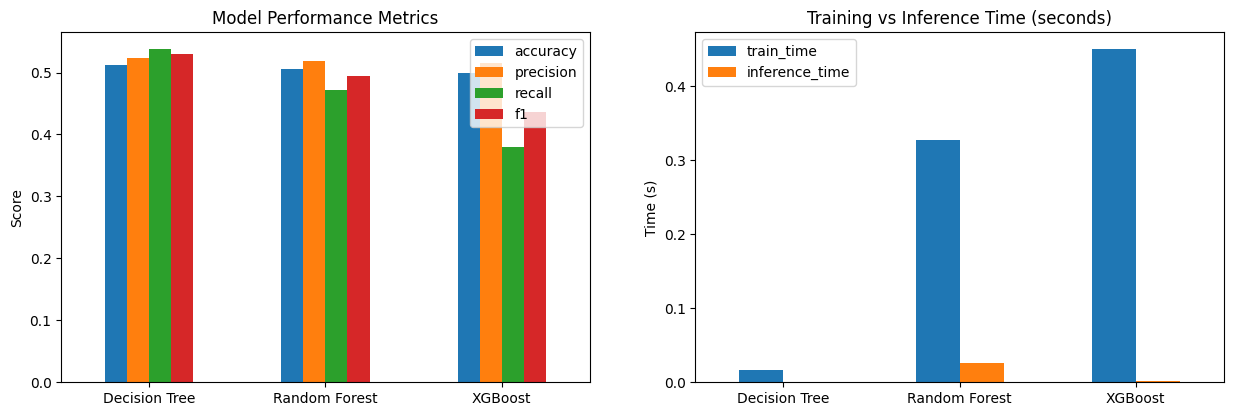

In [17]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, confusion_matrix)

# 1. Model Training & Evaluation Function
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'inference_time': pred_time
    }
    return metrics, y_pred

# 2. Initialize Models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
}

# 3. Train and Evaluate All Models
results = {}
predictions = {}

for name, model in models.items():
    metrics, y_pred = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    results[name] = metrics
    predictions[name] = y_pred

# 4. Create Comparison DataFrame
comparison_df = pd.DataFrame(results).T
print("Model Comparison:")
print(comparison_df)

# 5. Visualization
plt.figure(figsize=(15, 10))

# Metric Comparison
plt.subplot(2, 2, 1)
comparison_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)

# Runtime Comparison
plt.subplot(2, 2, 2)
comparison_df[['train_time', 'inference_time']].plot(kind='bar', ax=plt.gca())
plt.title('Training vs Inference Time (seconds)')
plt.ylabel('Time (s)')
plt.xticks(rotation=0)

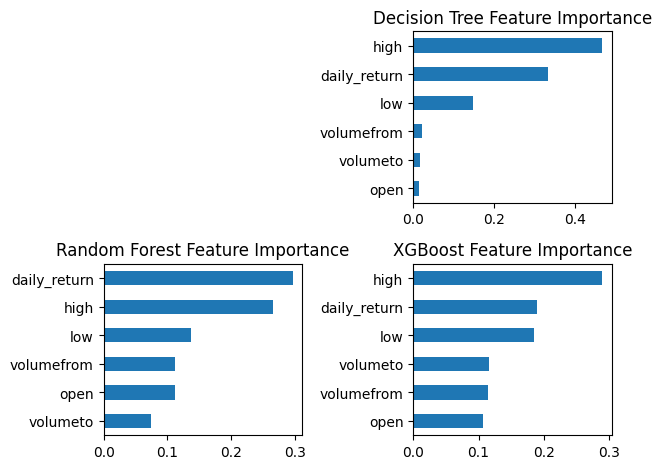

In [15]:
# Feature Importance
for i, (name, model) in enumerate(models.items(), 3):
    plt.subplot(2, 2, i-1)
    if hasattr(model, 'feature_importances_'):
        pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')
    elif hasattr(model, 'coef_'):
        pd.Series(model.coef_[0], index=X_train.columns).sort_values().plot(kind='barh')
    plt.title(f'{name} Feature Importance')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

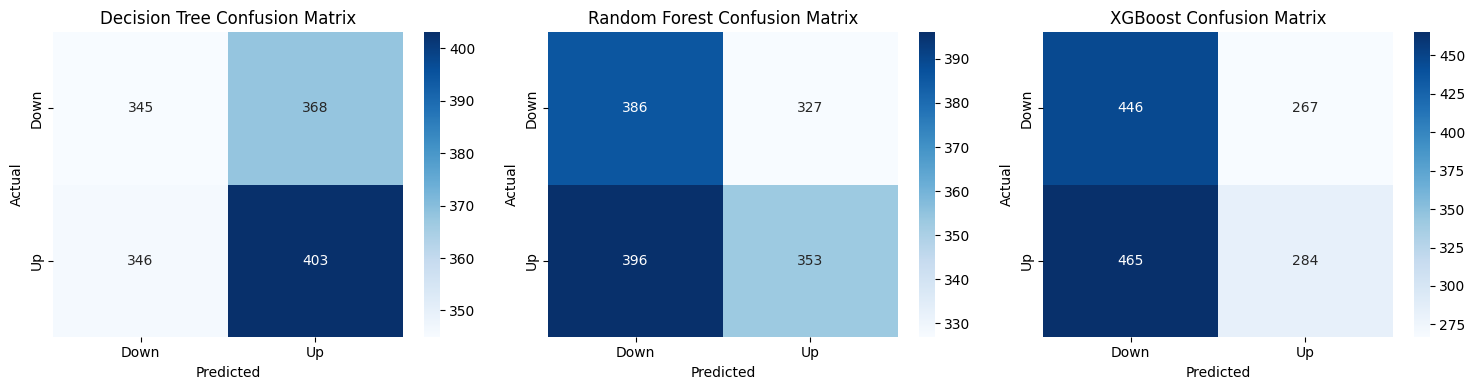

Comparison results saved to model_comparison_results.csv


In [ ]:
# Confusion Matrices
plt.figure(figsize=(15, 4))
for i, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Down', 'Up'], 
                yticklabels=['Down', 'Up'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 7. Save Results
comparison_df.to_csv('model_comparison_results.csv')
print("Comparison results saved to model_comparison_results.csv")